<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

Se utiliza el mismo libro que el desafio 3 "Los juegos del hambre".

In [4]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import re
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [9]:
# Ruta de la carpeta que contiene los libros
dataset_path = '/content/drive/My Drive/Colab Notebooks/hungergames.txt'

# Lista para almacenar los capítulos
corpus = []

# Abro el archivo y lee las líneas
with open(dataset_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Inicializo una variable para el capítulo actual
current_chapter = ''

# Recorro las líneas del archivo
for line in lines:
    # la línea contiene el nombre del capítulo entre guiones bajos
    if re.match(r'_+\s+\d+\s+_+', line):
        # Agrego el capítulo actual al corpus si no está vacío
        if current_chapter:
            corpus.append(current_chapter.strip())
        # Inicializo el capítulo actual con la línea actual
        current_chapter = line
    else:
        # Agrego la línea al capítulo actual
        current_chapter += line

# Añado el último capítulo al corpus
if current_chapter:
    corpus.append(current_chapter.strip())

# Imprimo el número de capítulos y el corpus
#print(f'Número de capítulos: {len(corpus)}')

# Inicializa una lista para almacenar las oraciones
sentences = []

# Divido cada capítulo en oraciones
for text in corpus:
    chapter_sentences = text.split('\n')
    chapter_sentences = [sentence.strip() for sentence in chapter_sentences if sentence.strip()]
    sentences.extend(chapter_sentences)

df = pd.DataFrame({'Oraciones': sentences})
print("Cantidad de oraciones:", df.shape[0])

Cantidad de oraciones: 9141


In [35]:
df.head(10)

,Oraciones
0,LOS JUEGOS DEL HAMBRE
1,"(Saga: ""Distritos"", vol.1)"
2,Suzanne Collins
3,"© 2008, The hunger games"
4,Traducción: Pilar Ramírez Tello
5,PRIMERA PARTE:
6,LOS TRIBUTOS
7,_____ 1 _____
8,"Cuando me despierto, el otro lado de la cama e..."
9,"dedos buscando el calor de Prim, pero no encue..."


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [11]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [36]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.iloc[8,0]
text

'Cuando me despierto, el otro lado de la cama está frío. Estiro los'

In [37]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['cuando',
 'me',
 'despierto',
 'el',
 'otro',
 'lado',
 'de',
 'la',
 'cama',
 'está',
 'frío',
 'estiro',
 'los']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [40]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[8:].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [44]:
# Demos un vistazo
sentence_tokens[8:10]

[['tan',
  'machacada',
  'la',
  'cara',
  'de',
  'prim',
  'es',
  'tan',
  'fresca',
  'como',
  'una',
  'gota',
  'de',
  'agua',
  'tan'],
 ['encantadora',
  'como',
  'la',
  'prímula',
  'que',
  'le',
  'da',
  'nombre',
  'mi',
  'madre',
  'también',
  'fue',
  'muy']]

In [45]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [46]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences

[['cuando', 'me', 'despierto', 'el'],
 ['me', 'despierto', 'el', 'otro'],
 ['despierto', 'el', 'otro', 'lado'],
 ['el', 'otro', 'lado', 'de'],
 ['otro', 'lado', 'de', 'la'],
 ['lado', 'de', 'la', 'cama'],
 ['de', 'la', 'cama', 'está'],
 ['la', 'cama', 'está', 'frío'],
 ['cama', 'está', 'frío', 'estiro']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [47]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [48]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[11, 9, 7, 1],
 [9, 7, 1, 2],
 [7, 1, 2, 3],
 [1, 2, 3, 4],
 [2, 3, 4, 5],
 [3, 4, 5, 6],
 [4, 5, 6, 8],
 [5, 6, 8, 10],
 [6, 8, 10, 12]]

In [49]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

9


In [50]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

12


In [51]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'el': 1, 'otro': 2, 'lado': 3, 'de': 4, 'la': 5, 'cama': 6, 'despierto': 7, 'está': 8, 'me': 9, 'frío': 10, 'cuando': 11, 'estiro': 12}


In [52]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'me': 2, 'el': 4, 'despierto': 3, 'cuando': 1, 'otro': 4, 'lado': 4, 'de': 4, 'la': 4, 'cama': 4, 'está': 3, 'frío': 2, 'estiro': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [53]:
# Vistazo a las primeras filas
df.iloc[:15,0]

0                                 LOS JUEGOS DEL HAMBRE
1                            (Saga: "Distritos", vol.1)
2                                       Suzanne Collins
3                              © 2008, The hunger games
4                       Traducción: Pilar Ramírez Tello
5                                        PRIMERA PARTE:
6                                          LOS TRIBUTOS
7                                         _____ 1 _____
8     Cuando me despierto, el otro lado de la cama e...
9     dedos buscando el calor de Prim, pero no encue...
10    funda de lona del colchón. Seguro que ha tenid...
11    en la cama de nuestra madre; claro que sí, por...
12    Me apoyo en un codo y me levanto un poco; en e...
13    algo de luz, así que puedo verlas. Mi hermana ...
14    a su lado, protegida por el cuerpo de mi madre...
Name: Oraciones, dtype: object

In [55]:
# Concatenamos todos los rows en un solo valor

corpus = df.iloc[8:].apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Cuando me despierto, el otro lado de la cama está frío. Estiro los dedos buscando el calor de Prim, pero no encuentro más que la basta funda de lona del colchón. Seguro que ha tenido pesadillas y se ha metido en la cama de nuestra madre; claro que sí, porque es el día de la cosecha. Me apoyo en un codo y me levanto un poco; en el dormitorio entra algo de luz, así que puedo verlas. Mi hermana pequeña, Prim, acurrucada a su lado, protegida por el cuerpo de mi madre, las dos con las mejillas pegadas. Mi madre parece más joven cuando duerme; agotada, aunque no tan machacada. La cara de Prim es tan fresca como una gota de agua, tan encantadora como la prímula que le da nombre. Mi madre también fue muy guapa hace tiempo, o eso me han dicho. Sentado sobre las rodillas de Prim, para protegerla, está el gato más feo del mundo: hocico aplastado, media oreja arrancada y ojos del color de un calabacín podrido. Prim le puso Buttercup porque, según ella, su pelaje amarillo embarrado tenía el mismo 

In [56]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['cuando',
 'me',
 'despierto',
 'el',
 'otro',
 'lado',
 'de',
 'la',
 'cama',
 'está',
 'frío',
 'estiro',
 'los',
 'dedos',
 'buscando',
 'el',
 'calor',
 'de',
 'prim',
 'pero']

In [57]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 100011


In [58]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [59]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['cuando', 'me', 'despierto', 'el'],
 ['me', 'despierto', 'el', 'otro'],
 ['despierto', 'el', 'otro', 'lado'],
 ['el', 'otro', 'lado', 'de'],
 ['otro', 'lado', 'de', 'la'],
 ['lado', 'de', 'la', 'cama'],
 ['de', 'la', 'cama', 'está'],
 ['la', 'cama', 'está', 'frío'],
 ['cama', 'está', 'frío', 'estiro'],
 ['está', 'frío', 'estiro', 'los'],
 ['frío', 'estiro', 'los', 'dedos'],
 ['estiro', 'los', 'dedos', 'buscando'],
 ['los', 'dedos', 'buscando', 'el'],
 ['dedos', 'buscando', 'el', 'calor'],
 ['buscando', 'el', 'calor', 'de'],
 ['el', 'calor', 'de', 'prim'],
 ['calor', 'de', 'prim', 'pero'],
 ['de', 'prim', 'pero', 'no'],
 ['prim', 'pero', 'no', 'encuentro'],
 ['pero', 'no', 'encuentro', 'más']]

In [60]:
# Proceso de tokenización
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[30, 8, 890, 5],
 [8, 890, 5, 102],
 [890, 5, 102, 149],
 [5, 102, 149, 1],
 [102, 149, 1, 3],
 [149, 1, 3, 345],
 [1, 3, 345, 32],
 [3, 345, 32, 438],
 [345, 32, 438, 3436],
 [32, 438, 3436, 10],
 [438, 3436, 10, 312],
 [3436, 10, 312, 1531],
 [10, 312, 1531, 5],
 [312, 1531, 5, 369],
 [1531, 5, 369, 1],
 [5, 369, 1, 98],
 [369, 1, 98, 22],
 [1, 98, 22, 9],
 [98, 22, 9, 350],
 [22, 9, 350, 26]]

In [61]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 100007


### 3 - Input y target

In [62]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [63]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [64]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [65]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(100007, 3)
(100007,)


In [66]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'que',
 3: 'la',
 4: 'y',
 5: 'el',
 6: 'a',
 7: 'en',
 8: 'me',
 9: 'no',
 10: 'los',
 11: 'un',
 12: 'lo',
 13: 'las',
 14: 'se',
 15: 'con',
 16: 'una',
 17: 'por',
 18: 'para',
 19: 'del',
 20: 'es',
 21: 'al',
 22: 'pero',
 23: 'mi',
 24: 'peeta',
 25: 'si',
 26: 'más',
 27: 'como',
 28: 'le',
 29: 'su',
 30: 'cuando',
 31: 'sin',
 32: 'está',
 33: 'nos',
 34: 'ha',
 35: 'porque',
 36: 'aunque',
 37: 'yo',
 38: 'después',
 39: 'él',
 40: 'todo',
 41: 'distrito',
 42: 'hasta',
 43: 'ya',
 44: 'así',
 45: 'sé',
 46: 'sólo',
 47: 'qué',
 48: 'tengo',
 49: 'haymitch',
 50: 'te',
 51: 'dos',
 52: 'algo',
 53: 'sobre',
 54: 'mí',
 55: 'he',
 56: 'nada',
 57: 'tan',
 58: 'vez',
 59: 'tiene',
 60: 'estoy',
 61: 'o',
 62: 'embargo',
 63: 'hay',
 64: 'todos',
 65: 'puedo',
 66: 'eso',
 67: 'poco',
 68: 'ella',
 69: 'sus',
 70: 'veo',
 71: 'dice',
 72: 'bien',
 73: 'hace',
 74: 'ni',
 75: 'rue',
 76: 'ahora',
 77: 'muy',
 78: 'momento',
 79: 'mis',
 80: 'antes',
 81: 'mientras'

In [67]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

10474

In [68]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size)

IndexError: ignored

In [69]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [70]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)
y_data.shape

(100007, 10474)

### 4 - Entrenar el modelo

In [71]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1]
input_seq_len

3

In [72]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

10474

In [73]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              52375     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 10474)             345642    
                                                                 
Total params: 451041 (1.72 MB)
Trainable params: 451041 

In [74]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
2501/2501 [==============================] - 49s 16ms/step - loss: 6.9458 - accuracy: 0.0429 - val_loss: 6.7081 - val_accuracy: 0.0432
Epoch 2/50
2501/2501 [==============================] - 31s 12ms/step - loss: 6.5263 - accuracy: 0.0513 - val_loss: 6.6854 - val_accuracy: 0.0560
Epoch 3/50
2501/2501 [==============================] - 31s 12ms/step - loss: 6.2952 - accuracy: 0.0653 - val_loss: 6.6328 - val_accuracy: 0.0632
Epoch 4/50
2501/2501 [==============================] - 30s 12ms/step - loss: 6.0798 - accuracy: 0.0719 - val_loss: 6.6233 - val_accuracy: 0.0714
Epoch 5/50
2501/2501 [==============================] - 31s 12ms/step - loss: 5.8974 - accuracy: 0.0840 - val_loss: 6.6425 - val_accuracy: 0.0806
Epoch 6/50
2501/2501 [==============================] - 31s 13ms/step - loss: 5.7266 - accuracy: 0.0912 - val_loss: 6.6501 - val_accuracy: 0.0857
Epoch 7/50
2501/2501 [==============================] - 31s 12ms/step - loss: 5.5941 - accuracy: 0.0970 - val_loss: 6.7345 -

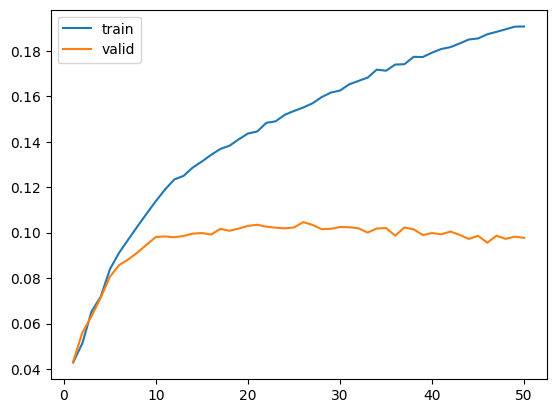

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [76]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [77]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 7.8 MB/s eta 0:

In [88]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

<ipython-input-88-2a8fe09160a6>:24: GradioDeprecationWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 19ms/step
Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

In [79]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [84]:
input_text='ella es voluntaria del distrito'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 31ms/step


'ella es voluntaria del distrito desde de'

### 7 - Beam search y muestreo aleatorio

In [85]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=3):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [86]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [87]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="ella gano los juegos")

1/1 [==============================] - 0s 27ms/step


In [89]:
# veamos las salidas
decode(salidas[0])

['gano los juegos la cosas a plana']

### 8 - Conclusiones
El modelo entrenado en "Los Juegos del Hambre" presenta dificultades, como podemos ver tiene una incapacidad de comprender incluso frases simples como "los juegos del" omitiendo la palabra hambre. Para mejorar su desempeño, algunas sugerencias podrian ser una revisión en la arquitectura del modelo, considerando la incorporación de redes neuronales recurrentes bidireccionales (BRNN) para capturar mejor el contexto literario.
Además, un preprocesamiento más riguroso, incluyendo la eliminación de conectores y palabras redundantes, podría ayudar a enfocar el modelo en información relevante. Adenas, se debe cambiar en el número de épocas de entrenamiento, junto con técnicas de regularización, para evitar el sobreajuste como ocurrio en este caso.